# Imports

In [1]:
# %% Imports
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import summarize
import torch
import numpy as np
from data_utils.datamodules import SimpleMicroDataModule, AlignedMicroDataModule
from models import CNNTransformer, Transformer, TCN_classifier, TemporalConvRNN, Seq2SeqRNN
import data_utils.augmentations as augs
import csv

import os
import sys
sys.path.append('..')
from alignment import alignment_utils as utils
from alignment.AlignCCA import AlignCCA

# Define data module

In [2]:
data_filename = os.path.expanduser('~/data/pt_decoding_data_S62.pkl')
# data_filename = ('../data/pt_decoding_data_S62.pkl')
pt_data = utils.load_pkl(data_filename)

In [3]:
pt = 'S26'
p_ind = 1
lab_type = 'phon'
algn_type = 'phon_seq'
tar_data, pre_data = utils.decoding_data_from_dict(pt_data, pt, p_ind,
                                                   lab_type=lab_type,
                                                   algn_type=algn_type)
print([d.shape for d in tar_data])
print([[d.shape for d in p] for p in pre_data])

[(148, 200, 111), (148,), (148, 3)]
[[(144, 200, 111), (144,), (144, 3)], [(151, 200, 63), (151,), (151, 3)], [(46, 200, 149), (46,), (46, 3)], [(151, 200, 74), (151,), (151, 3)], [(137, 200, 144), (137,), (137, 3)], [(141, 200, 171), (141,), (141, 3)], [(178, 200, 201), (178,), (178, 3)]]


In [4]:
fold_data_path = os.path.expanduser('~/workspace/transformer_data')
# fold_data_path = '.'

fs = 200 # Hz
# augmentations = [augs.time_warping, augs.time_masking, augs.time_shifting, augs.noise_jitter, augs.scaling]
augmentations = [augs.time_shifting, augs.noise_jitter, augs.scaling]
# augmentations = None
# data = torch.rand(n_samples, n_timepoints, n_features)
# labels = torch.randint(0, 9, (n_samples,))
# data = torch.Tensor(all_pt_dict['S14']['X1'])
# labels = torch.Tensor(all_pt_dict['S14']['y1']).long() - 1
data = torch.Tensor(tar_data[0])
labels = torch.Tensor(tar_data[1]).long().unsqueeze(1) - 1
align_labels = torch.Tensor(tar_data[2]).long() - 1
# pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[1]).long().unsqueeze(1) - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]
pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[2]).long() - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]  # for seq2seq RNN
# data = torch.Tensor(all_pt_dict['S14']['X_collapsed'])
# labels = torch.Tensor(all_pt_dict['S14']['y_phon_collapsed']).long() - 1

# create the data module
batch_size = 5000
n_folds = 20
val_size = 0.1

context_prefix = 'ptSpecific'
# dm = SimpleMicroDataModule(data, labels, batch_size=batch_size, folds=n_folds,
#                            val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))
## modification of labels for seq2seq RNN ###
# dm = SimpleMicroDataModule(data, align_labels, batch_size=batch_size, folds=n_folds,
#                            val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))

# context_prefix = 'pooled'
# # dm = AlignedMicroDataModule(data, labels, align_labels, pool_data, AlignCCA,
# #                             batch_size=batch_size, folds=n_folds, val_size=val_size,
# #                             augmentations=augmentations, data_path=fold_data_path)
dm = AlignedMicroDataModule(data, align_labels, align_labels, pool_data, AlignCCA,
                            batch_size=batch_size, folds=n_folds, val_size=val_size,
                            augmentations=augmentations, data_path=fold_data_path)
# dm.setup()

In [5]:
dm.train_dataloader().dataset.tensors[1].shape

torch.Size([4352, 3])

# Define model

In [6]:
from pytorch_lightning.utilities.model_summary import summarize


gclip_val = 0.5

##### CNN TRANSFORMER #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# d_model = 128
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_head = 8
# num_layers = 2
# dim_fc = 64
# # dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# tform_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
#                            n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate)


##### Temporal CNN classifier #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
#                            cnn_dropout, learning_rate, l2_reg)


##### Temporal CNN GRU #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# n_filters = 100
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_layers = 1
# hidden_size = 500
# dim_fc = [128, 64]
# cnn_dropout = 0.3
# rnn_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# activ = True

# sum_model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
#                             kernel_size, dim_fc, stride, padding, cnn_dropout,
#                             rnn_dropout, learning_rate, l2_reg)



##### Seq2Seq RNN #####
# model parameters
in_channels = data.shape[-1]
num_classes = 9
n_filters = 100
# d_model = data.shape[-1]
kernel_time = 50  # ms
kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
stride_time = 50  # ms
stride = int(stride_time * fs / 1000)  # stride length in samples
padding = 0
n_enc_layers = 2
n_dec_layers = 1
hidden_size = 500
cnn_dropout = 0.3
rnn_dropout = 0.3
learning_rate = 1e-4
l2_reg = 1e-5
activ = False
model_type = 'gru'

sum_model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                       n_dec_layers, kernel_size, stride, padding, cnn_dropout,
                       rnn_dropout, model_type, learning_rate, l2_reg)

print(summarize(sum_model))

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0      | train
1 | temporal_conv | TemporalConv     | 111 K  | train
2 | encoder       | EncoderRNN       | 6.3 M  | train
3 | decoder       | DecoderRNN       | 1.5 M  | train
-----------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.743    Total estimated model params size (MB)


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Train model

In [7]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "The number of training batches.*")

In [8]:
# instantiate the trainer
max_epochs = 500
# es_pat = max_steps // 20
# max_steps = 500
es_pat = 50
warmup = 100
# callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
log_dir = os.path.expanduser('~/workspace/transformer_data/transformer_logs')

In [9]:
# class MetricCollector(L.Callback):
#     def __init__(self):
#         self.metrics = {}
#     
#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.metrics['val_loss'] = trainer.logger.metrics['val_loss']
#         self.metrics['val_acc'] = trainer.logger.metrics['val_acc']
#     
#     def on_test_epoch_end(self, trainer, pl_module):
#         self.metrics['test_loss'] = trainer.logger.metrics['test_loss']
#         self.metrics['test_acc'] = trainer.logger.metrics['test_acc']

In [10]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

def cmat_acc(y_hat, y, num_classes):
    y_pred = torch.argmax(y_hat, dim=1)
    cmat = multiclass_confusion_matrix(y_pred, y, num_classes)
    acc_cmat = cmat.diag().sum() / cmat.sum()
    return acc_cmat

In [11]:
# train the model
n_iters = 1
iter_accs = []
for i in range(n_iters):
    print(f'##### Setting up data module for iteration {i+1} #####')
    dm.setup()
    
    fold_accs = []
    # y_pred_all = []
    # y_test_all = []
    for fold in range(n_folds):
        # if fold > 1:
        #     break
        dm.set_fold(fold)
        # print(dm.current_fold)
        
        # instantiate the model
        in_channels = dm.get_data_shape()[-1]
        # print(in_channels)
        # model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
        #                        n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate,
        #                        warmup, max_steps, l2_reg, activation=activ)
        # model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
        #                            cnn_dropout, learning_rate, l2_reg, activation=activ)
        # model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
                                # kernel_size, dim_fc, stride, padding, cnn_dropout,
                                # rnn_dropout, learning_rate, l2_reg, activation=activ,
                                # decay_iters=max_epochs)
        model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                           n_dec_layers, kernel_size, stride, padding, cnn_dropout, rnn_dropout, model_type,
                           learning_rate, l2_reg, activation=activ, decay_iters=max_epochs)
        
        # model.current_fold = fold
        callbacks = [
            # ModelCheckpoint(monitor='val_loss', mode='min'),
            ModelCheckpoint(monitor='val_acc', mode='max'),
            # EarlyStopping(monitor='val_loss', patience=es_pat),
            LearningRateMonitor(logging_interval='epoch'),
            ]
        trainer = L.Trainer(default_root_dir=log_dir,
                            max_epochs=max_epochs,
                            # max_steps=max_steps,
                            gradient_clip_val=gclip_val,
                            accelerator='auto',
                            callbacks=callbacks,
                            logger=True,
                            enable_model_summary=False,
                            enable_progress_bar=False,
                           )
        # # trainer.fit(model, dm)
        trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
        print(trainer.logged_metrics)
        # print(trainer.callback_metrics)
        # print the training metrics from the best model checkpoint
        # print(f'Fold {fold} best model metrics:')
        # print(trainer.checkpoint_callback.best_model_score)


        # trainer.test(model, dm)
        # model = CNNTransformer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=dm.test_dataloader(), ckpt_path='best')
        # trainer.test(dataloaders=dm.test_dataloader(), ckpt_path='best')

        # test_pred = model(dm.test_dataloader().dataset.tensors[0])
        # test_pred = trainer.predict(model, dm.test_dataloader(), ckpt_path='best)[0]
        # test_pred = torch.argmax(test_pred, dim=1)
        # print(test_pred)
        # y_pred_all.extend(test_pred)
        # y_test_all.extend(dm.test_dataloader().dataset.tensors[1])
        
        fold_accs.append(trainer.logged_metrics['test_acc'])
    
        # save loss information
        # loss_dict = trainer.logger.metrics
        # loss_dict['fold'] = fold
        # loss_dict['model'] = model
    # acc = cmat_acc(torch.stack(y_pred_all), torch.stack(y_test_all), num_classes)
    # print(acc)
    # iter_accs.append(acc)
    # print(f'Averaged accuracy: {sum(fold_accs) / len(fold_accs)}')
    iter_accs.append(fold_accs)
    with open(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs_iter{i+1}.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerows(iter_accs)
    print(np.mean(fold_accs))
# print(sum(iter_accs) / len(iter_accs), iter_accs)
print(iter_accs)
with open(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerows(iter_accs)
np.save(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs.npy'), np.array(iter_accs))

##### Setting up data module for iteration 1 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Sta

{'train_loss': tensor(0.0225), 'train_acc': tensor(0.9995), 'val_loss': tensor(2.9626), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2166/checkpoints/epoch=98-step=99.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss            1.662295937538147
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2167/checkpoints/epoch=63-step=64.ckpt


{'train_loss': tensor(0.0241), 'train_acc': tensor(0.9996), 'val_loss': tensor(2.8486), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2167/checkpoints/epoch=63-step=64.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           1.5435501337051392
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2168/checkpoints/epoch=95-step=96.ckpt


{'train_loss': tensor(0.0290), 'train_acc': tensor(0.9982), 'val_loss': tensor(2.4396), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2168/checkpoints/epoch=95-step=96.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss            1.094774603843689
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2169/checkpoints/epoch=66-step=67.ckpt


{'train_loss': tensor(0.0235), 'train_acc': tensor(0.9994), 'val_loss': tensor(2.2534), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2169/checkpoints/epoch=66-step=67.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.25
        test_loss            1.85834538936615
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2170/checkpoints/epoch=73-step=74.ckpt


{'train_loss': tensor(0.0250), 'train_acc': tensor(0.9993), 'val_loss': tensor(4.0255), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2170/checkpoints/epoch=73-step=74.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss           1.4842332601547241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2171/checkpoints/epoch=120-step=121.ckpt


{'train_loss': tensor(0.0240), 'train_acc': tensor(0.9990), 'val_loss': tensor(2.8771), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2171/checkpoints/epoch=120-step=121.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss           1.6716084480285645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2172/checkpoints/epoch=298-step=299.ckpt


{'train_loss': tensor(0.0210), 'train_acc': tensor(0.9995), 'val_loss': tensor(1.8797), 'val_acc': tensor(0.5714)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2172/checkpoints/epoch=298-step=299.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss            3.346935272216797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2173/checkpoints/epoch=140-step=141.ckpt


{'train_loss': tensor(0.0236), 'train_acc': tensor(0.9991), 'val_loss': tensor(1.8965), 'val_acc': tensor(0.6429)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2173/checkpoints/epoch=140-step=141.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.2339043617248535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2174/checkpoints/epoch=122-step=123.ckpt


{'train_loss': tensor(0.0270), 'train_acc': tensor(0.9988), 'val_loss': tensor(2.8683), 'val_acc': tensor(0.4222)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2174/checkpoints/epoch=122-step=123.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss            1.012373685836792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2175/checkpoints/epoch=139-step=140.ckpt


{'train_loss': tensor(0.0233), 'train_acc': tensor(0.9995), 'val_loss': tensor(2.2853), 'val_acc': tensor(0.4667)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2175/checkpoints/epoch=139-step=140.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.4111121892929077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2176/checkpoints/epoch=82-step=83.ckpt


{'train_loss': tensor(0.0239), 'train_acc': tensor(0.9989), 'val_loss': tensor(2.2239), 'val_acc': tensor(0.4889)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2176/checkpoints/epoch=82-step=83.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6891577243804932
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2177/checkpoints/epoch=342-step=343.ckpt


{'train_loss': tensor(0.0226), 'train_acc': tensor(0.9991), 'val_loss': tensor(2.9493), 'val_acc': tensor(0.4222)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2177/checkpoints/epoch=342-step=343.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7142857313156128
        test_loss           1.0994298458099365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2178/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0225), 'train_acc': tensor(0.9996), 'val_loss': tensor(2.4630), 'val_acc': tensor(0.4222)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2178/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.181239604949951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2179/checkpoints/epoch=136-step=137.ckpt


{'train_loss': tensor(0.0246), 'train_acc': tensor(0.9985), 'val_loss': tensor(2.8388), 'val_acc': tensor(0.4444)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2179/checkpoints/epoch=136-step=137.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.2276369333267212
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2180/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0324), 'train_acc': tensor(0.9976), 'val_loss': tensor(2.3529), 'val_acc': tensor(0.4444)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2180/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6190476417541504
        test_loss            1.077764630317688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2181/checkpoints/epoch=148-step=149.ckpt


{'train_loss': tensor(0.0221), 'train_acc': tensor(0.9991), 'val_loss': tensor(1.9301), 'val_acc': tensor(0.4889)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2181/checkpoints/epoch=148-step=149.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3918503522872925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2182/checkpoints/epoch=162-step=163.ckpt


{'train_loss': tensor(0.0237), 'train_acc': tensor(0.9994), 'val_loss': tensor(3.5698), 'val_acc': tensor(0.4000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2182/checkpoints/epoch=162-step=163.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           2.0612735748291016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2183/checkpoints/epoch=216-step=217.ckpt


{'train_loss': tensor(0.0238), 'train_acc': tensor(0.9990), 'val_loss': tensor(2.0558), 'val_acc': tensor(0.5111)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2183/checkpoints/epoch=216-step=217.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.4368979930877686
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2184/checkpoints/epoch=96-step=97.ckpt


{'train_loss': tensor(0.0208), 'train_acc': tensor(0.9994), 'val_loss': tensor(2.9041), 'val_acc': tensor(0.3556)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2184/checkpoints/epoch=96-step=97.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6190476417541504
        test_loss           1.0035786628723145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2185/checkpoints/epoch=310-step=311.ckpt


{'train_loss': tensor(0.0244), 'train_acc': tensor(0.9993), 'val_loss': tensor(2.3134), 'val_acc': tensor(0.5556)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2185/checkpoints/epoch=310-step=311.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.9801785945892334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.46785718
[[tensor(0.4167), tensor(0.4167), tensor(0.6667), tensor(0.2500), tensor(0.5000), tensor(0.4583), tensor(0.4583), tensor(0.3333), tensor(0.5714), tensor(0.4762), tensor(0.4286), tensor(0.7143), tensor(0.2857), tensor(0.4762), tensor(0.6190), tensor(0.5238), tensor(0.4286), tensor(0.2381), tensor(0.6190), tensor(0.4762)]]


In [15]:
iter_accs = np.load(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs.npy'))
print(iter_accs.shape)
print(iter_accs.mean(axis=1))
print(iter_accs.mean())

(1, 20)
[0.46785718]
0.46785718


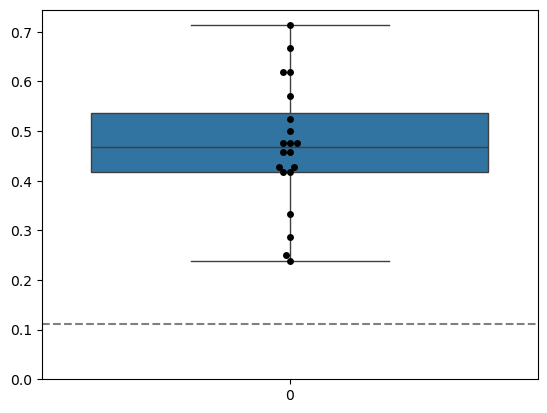

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# from torch import tensor
# test = [[tensor(0.5000), tensor(0.3636), tensor(0.2727), tensor(0.4545), tensor(0.3182), tensor(0.4545), tensor(0.4091), tensor(0.2273), tensor(0.2727), tensor(0.4091), tensor(0.2727), tensor(0.3182), tensor(0.3333), tensor(0.3333), tensor(0.4762), tensor(0.3333), tensor(0.2857), tensor(0.3810), tensor(0.3810), tensor(0.3810)]]
# plt.boxplot(iter_accs.mean(axis=1))
# sns.boxplot(data=iter_accs.mean(axis=1))
# sns.swarmplot(data=iter_accs.mean(axis=1), color='black')
sns.boxplot(data=iter_accs.T)
sns.swarmplot(data=iter_accs.T, color='black')
plt.axhline(y=1/9, color='gray', linestyle='--')
plt.ylim(0, None)
plt.show()

In [19]:

np.mean(fold_accs)

0.46785718